<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/J-TKim/Gans_in_action/blob/master/Ch3/Ch3_GAN.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

In [1]:
# 코드 3-1 모듈 임포트
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
# 코드 3-2 모델 입력 차원
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels) # 입력 이미지 차원

z_dim = 100 # 생성자의 입력으로 사용될 잡음 벡터의 크기

In [3]:
# 코드 3-3 생성자
def build_generator(img_shape, z_dim):
    model = Sequential()
    model.add(Dense(128, input_dim = z_dim)) # 완전 연결층
    model.add(LeakyReLU(alpha=0.01)) # LeakyReLU 활성화 함수
    model.add(Dense(28 * 28 * 1, activation="tanh")) # tanh 활성화 함수를 사용한 출력층
    model.add(Reshape(img_shape))
    return model

In [4]:
# 코드 3-4 판별자
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape)) # 입력 이미지를 일렬로 펼치기
    model.add(Dense(128)) # 완전 연결층
    model.add(LeakyReLU(alpha=0.01)) # LeakyReLU 활성화 함수
    model.add(Dense(1, activation="sigmoid")) # 시그모이드 활성화 함수를 사용한 출력층
    return model

In [5]:
# 코드 3-5 GAN 모델 만들기와 컴파일
def build_gan(generator, discriminator):
    
    model = Sequential()
    
    model.add(generator) # 생성자 + 판별자 모델 연결
    
    model.add(discriminator)
    
    return model

In [6]:
discriminator = build_discriminator(img_shape) # 판별자 모델 만들고 컴파일하기
discriminator.compile(loss = "binary_crossentropy",
                     optimizer=Adam(),
                     metrics=["acc"])

In [7]:
generator = build_generator(img_shape, z_dim) # 생성자 모델 만들기

In [8]:
discriminator.trainable = False # 생성자 훈련할 때 파라미터 동결하기

In [9]:
gan = build_gan(generator, discriminator) # 생성자를 훈련하기 위해 동결한 판별자로 GAN모델 만들고 컴파일하기
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [10]:
# 코드 3-6 GAN 훈련 반복
losses = []
accuracies = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # MNIST 데이터셋 로드
    (X_train, _), (_, _) = mnist.load_data()

    # [0, 255] 흑백 픽셀 값을 [-1, 1] 사이로 스케일 조정
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # 진짜 이미지 레이블: 모두 1
    real = np.ones((batch_size, 1))

    # 가짜 이미지 레이블: 모두 0
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  판별자 훈련
        # -------------------------

        # 진짜 이미지에서 랜덤 배치 가져오기
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # 가짜 이미지 배치 생성
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # 판별자 훈련
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  생성자 훈련
        # ---------------------

        # 가짜 이미지 배치 생성
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        # 생성자 훈련
        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            # 훈련이 끝난 후 그래프를 그리기 위해 손실과 정확도 저장
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            # 훈련 과정 출력
            print("%d [D 손실: %f, 정확도: %.2f%%] [G 손실: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            # 생성된 이미지 샘플 출력
            sample_images(generator)
            

In [11]:
# 코드 3-7 생성된 이미지 출력
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # 랜덤한 잡음 샘플링
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # 랜덤한 잡음에서 이미지 생성하기
    gen_imgs = generator.predict(z)

    # 이미지 픽셀 값을 [0, 1] 사이로 스케일 조정
    gen_imgs = 0.5 * gen_imgs + 0.5

    # 이미지 그리드 설정
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # 이미지 그리드 출력
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

1000 [D 손실: 0.031306, 정확도: 99.61%] [G 손실: 4.253561]
2000 [D 손실: 0.165559, 정확도: 93.36%] [G 손실: 8.882193]
3000 [D 손실: 0.120320, 정확도: 96.48%] [G 손실: 4.841583]
4000 [D 손실: 0.211818, 정확도: 90.62%] [G 손실: 4.638120]
5000 [D 손실: 0.160700, 정확도: 94.53%] [G 손실: 5.445217]
6000 [D 손실: 0.303539, 정확도: 86.72%] [G 손실: 4.058262]
7000 [D 손실: 0.151259, 정확도: 92.97%] [G 손실: 5.192830]
8000 [D 손실: 0.257606, 정확도: 90.23%] [G 손실: 3.839647]
9000 [D 손실: 0.276572, 정확도: 90.23%] [G 손실: 3.956149]
10000 [D 손실: 0.456058, 정확도: 81.64%] [G 손실: 3.639626]
11000 [D 손실: 0.334369, 정확도: 84.77%] [G 손실: 3.497199]
12000 [D 손실: 0.361073, 정확도: 83.98%] [G 손실: 3.632909]
13000 [D 손실: 0.403783, 정확도: 84.38%] [G 손실: 3.100169]
14000 [D 손실: 0.499412, 정확도: 79.30%] [G 손실: 2.670479]
15000 [D 손실: 0.369147, 정확도: 82.42%] [G 손실: 3.112942]
16000 [D 손실: 0.420517, 정확도: 82.42%] [G 손실: 2.344588]
17000 [D 손실: 0.442597, 정확도: 82.42%] [G 손실: 2.438829]
18000 [D 손실: 0.347760, 정확도: 87.11%] [G 손실: 2.926338]
19000 [D 손실: 0.547669, 정확도: 74.22%] [G 손실: 2.392479]
20

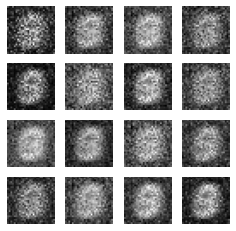

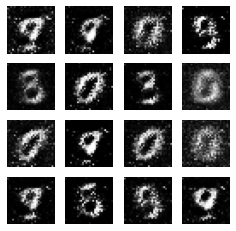

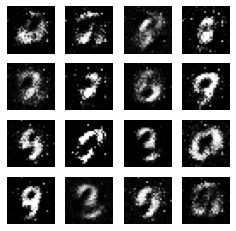

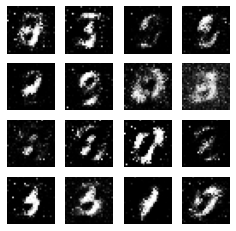

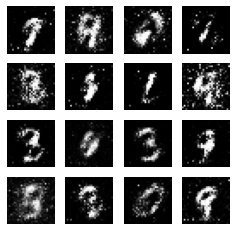

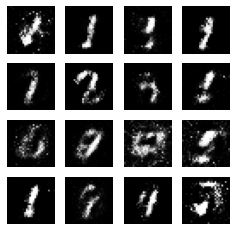

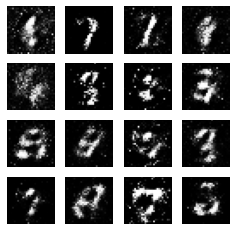

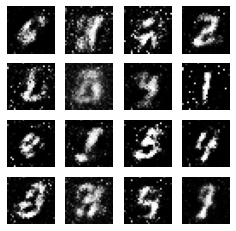

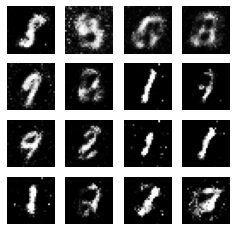

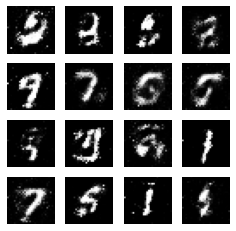

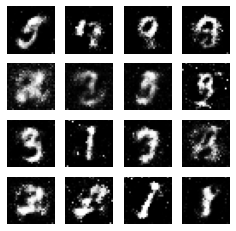

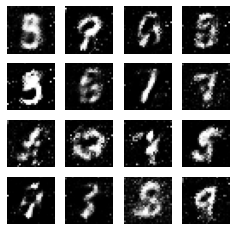

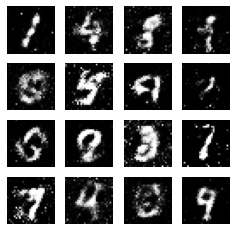

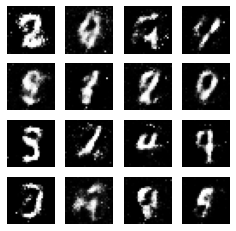

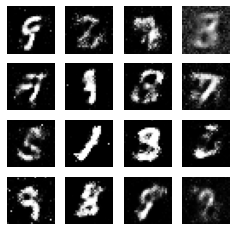

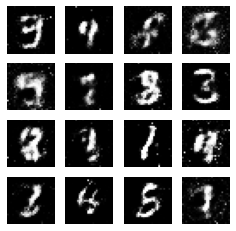

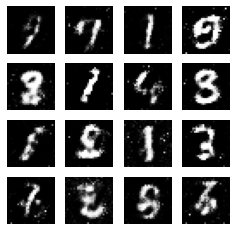

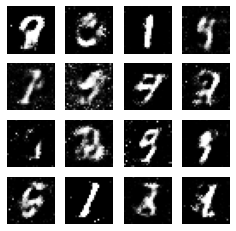

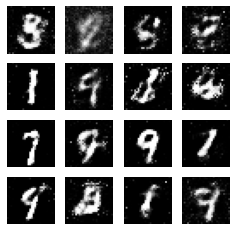

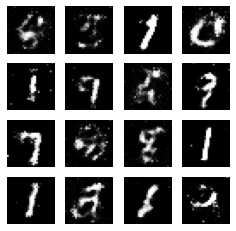

In [12]:
# 코드 3-8 모델 실행
iterations = 20000 # 하이퍼파라미터 설정
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval) # 지정한 횟수 동안 GAN 훈련

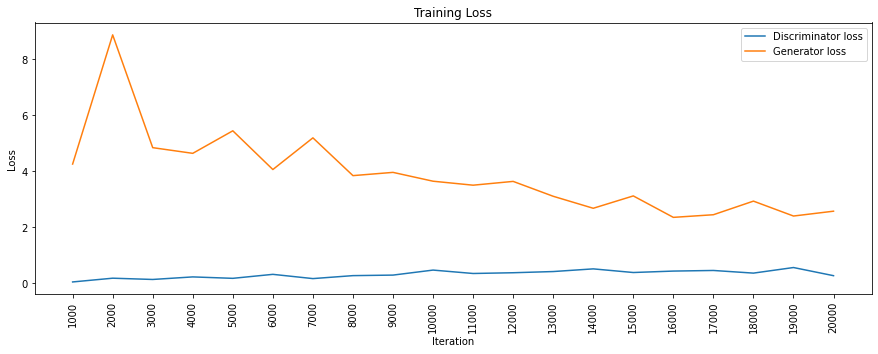

In [13]:
losses = np.array(losses)

# 판별자와 생성자의 훈련 손실 그래프
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

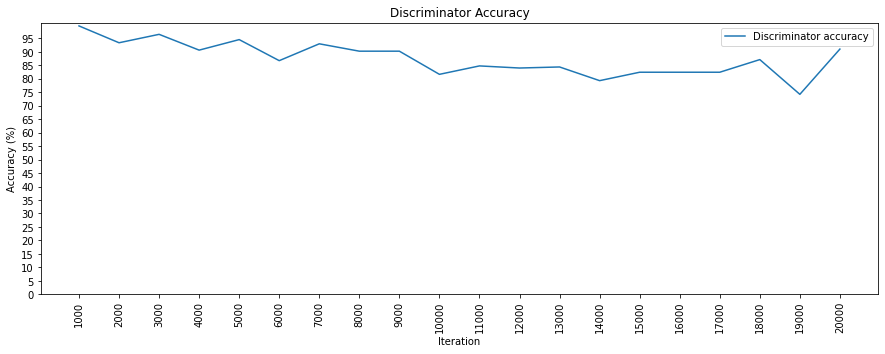

In [14]:
accuracies = np.array(accuracies)

# 판별자의 정확도 그래프
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()